# Research sandbox

Optimal velocity function: 

$V:s \mapsto V(s),$ \
$V(s) = \max\{0, \ v_0 -v_0\exp(-\lambda v_0^{-1}(s -s_{\text{jam}})) \},$ \
$V'(s) = H(s -s_{\text{jam}})\lambda\exp(-\lambda v_0^{-1}(s -s_{\text{jam}})),$ \
$V^{-1}(v) = -\lambda^{-1}v_0 \log(1-v_0^{-1}v)+s_{\text{jam}},\ 0<v<v_0.$

Heterogeneous OV Model with Relaxed Noise: 

$\begin{equation}
  \begin{cases}
    \dot \varepsilon_n = -b^{-1}\varepsilon_n +\sigma_R\sqrt{2 b^{-1}} \xi_n,\ b>0,\\
    \dot v_n = \tau_n^{-1}[{( V_n(s_n)+\varepsilon_n)\times w(\Delta t)-v_n}],\ \tau_n>0,\\
    \dot x_n = v_n,
  \end{cases}
\end{equation}$

$
\begin{equation}
  \begin{cases}
  \varepsilon_n(t+\delta) = (1-\delta \tilde b^{-1})\varepsilon_n(t) + \tilde\sigma_R\sqrt{\delta 2 \tilde b^{-1}} \eta_n,\ \eta_n \sim \mathcal{N}(0,\,1),\\
    v_n(t+\delta) = v_n(t) + \delta \frac{(V_n(s_n) +\varepsilon_n(t+\delta))\times w(\Delta t)-v_n(t)}{\tau_n},\\
    x_n(t+\delta) = x_n(t) + \delta v_n(t+\delta).
  \end{cases}
\end{equation}$

Anticipatory Operational Navigation: 

$\begin{equation}
  f(\alpha)=\min\{d_{\max}, v_0 \Delta t(\alpha)\}
\end{equation}$
$\begin{equation}
  d(\alpha)^2 = d_{\max}^2 +f(\alpha)^2 - 2 d_{\max}f(\alpha)\cos(\alpha_0-\alpha)
\end{equation}$
$\begin{equation}
  \alpha_{\text{des}} = \underset{}{\mathrm{argmin}} {d(\alpha)^2}
\end{equation}$
$\begin{equation}
  \dot \alpha = \tau^{-1}\left[\alpha_{\text{des}}-\alpha\right]
\end{equation}$

In [1]:
import os
import json
import zipfile
import logging
import warnings

In [2]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib import rcParams
from numpy.linalg import norm
from numpy import degrees, mean
from copy import deepcopy

In [3]:
from pNeuma_simulator import params
from pNeuma_simulator.results import loader, zipdir
from pNeuma_simulator.gang import decay
from pNeuma_simulator.initialization import ov

In [4]:
warnings.filterwarnings("ignore")
rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": "Helvetica",
        "mathtext.fontset": "stixsans",
        "mathtext.default": "regular",
        "font.size": 7,
        "axes.titlesize": 7,
        "xtick.labelsize": 6,
        "ytick.labelsize": 6,
        "axes.linewidth": 0.25,
        "xtick.major.width": 0.25,
        "ytick.major.width": 0.25,
        "xtick.minor.width": 0.25,
        "ytick.minor.width": 0.25,
        # "pdf.fonttype": 42,
    }
)
logging.getLogger("matplotlib.font_manager").disabled = True

In [5]:
# probe = False
# if probe:
#     permutation = (4, 6)
#     items = loader(permutation, path)
#     accidents = 0
#     locations = []
#     for item in items:
#         if isinstance(item[0], list):
#             pass
#         else:
#             locations.append(item)
#             accidents += 1
#     error = accidents / len(items)
#     print(error)

In [5]:
non_empty = []
empty = []
items = None
n_cars = 12
n_moto = 8
permutation = (n_cars, n_moto)
n_cars, n_moto = permutation
load = True
if load:
    items = loader(permutation, path="./output/")
for item in items:
    if isinstance(item[0], list):
        non_empty.append(item)
    else:
        empty.append(item)
len(non_empty)

(12, 8).json


253

In [ ]:
path = "./output/"
os.makedirs(path, exist_ok=True)
n_cars = 12
n_moto = 6
permutation = (n_cars, n_moto)

In [ ]:
# Dump to JSONL https://jsonlines.org/examples/
# https://stackoverflow.com/questions/38915183/
with open(f"{path}{permutation}.jsonl", "w") as outfile:
    for item in items:
        json.dump(item, outfile)
        outfile.write("\n")
# Compress as Zip and delete original JSON
with zipfile.ZipFile(f"{path}{permutation}.zip", "w", zipfile.ZIP_DEFLATED) as zipf:
    zipdir(path, zipf)

In [10]:
# def loader(permutation, verbose=True):
verbose = True
items = []
with zipfile.ZipFile(f"{path}{permutation}.zip", "r") as ziph:
    # ziph is zipfile handle
    for filename in ziph.namelist():
        if filename.endswith(").jsonl"):
            # Opening JSONL file
            with ziph.open(filename, "r") as openfile:
                # Reading from JSONL file
                # https://stackoverflow.com/questions/2081836/
                for i, line in enumerate(tqdm(openfile)):
                    item = json.loads(line)
                    if isinstance(item[0], list):
                        items.append(item)
                if verbose:
                    print(openfile.name)
#   return items

0it [00:00, ?it/s]

(12, 6).jsonl


In [ ]:
from math import exp
from scipy.optimize import minimize
from scipy.stats import linregress
from numpy import array, arange, where, unique
from numpy.polynomial import Polynomial
from pNeuma_simulator.results import percolate

In [ ]:
# Pseudorandom number generator
seed = 1024
rng = np.random.default_rng(seed)
T_max = round(exp(params.CM))
NU = 1.096854  # theoretical exponent for directed percolation in 1D

In [14]:
percolation = percolate(items, n_moto, rng, start=5)

In [15]:
def loss(x, y, x_star):
    renorm = np.abs(x - x_star)
    slope, _, _, _, _ = linregress(np.log(renorm)[y > 0], np.log(y[y > 0]))
    return abs(NU - slope)

In [16]:
def fit(x, y):
    # https://stackoverflow.com/questions/3843017/
    zero_crossings = where(np.diff(np.sign(y)))[0]
    x0 = x[zero_crossings[0]]
    # https://stackoverflow.com/questions/24767191/
    res = minimize(lambda x_star: loss(x, y, x_star), method="Nelder-Mead", x0=x0)
    popt = res.x[0]
    return popt

In [17]:
permutation = (12, 6)  # (12, 8)
x, y, low, high = percolation  # results[str(permutation)]["percolation"]
x, y, low, high = array(x), array(y), array(low), array(high)
T_c = fit(array(x), y)
renorm = abs(T_c - x)
slope, intercept, r_value, p_value, std_err = linregress(np.log(renorm)[y > 0], np.log(y[y > 0]))
p_c = 1 - T_c / T_max
print(abs(NU - slope), T_c, r_value**2)

2.911045019704517e-06 40.61800842285156 0.9961938799467054


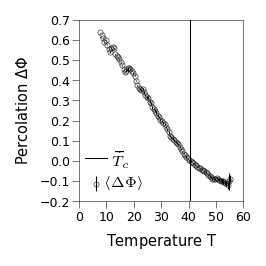

In [22]:
fig, ax = plt.subplots(figsize=(4 * params.cm, 4 * params.cm), dpi=150)
ax.errorbar(
    x,
    y,
    yerr=high - low,
    ms=5,
    fmt=".",
    mec="k",
    mfc="none",
    mew=0.25,
    ecolor="k",
    elinewidth=0.5,
    label="$\langle \Delta\Phi \\rangle$",
)
ax.text(
    0.4,
    0.06,
    f"$\langle \Delta\Phi \\rangle$",
    ha="right",
    va="bottom",
    fontsize=7,
    transform=ax.transAxes,
    bbox=dict(facecolor="w", edgecolor="w", boxstyle="round,pad=.1"),
    usetex=True,
    zorder=10,
)
ax.text(
    0.3,
    0.18,
    f"$T_c$",
    ha="right",
    va="bottom",
    fontsize=7,
    transform=ax.transAxes,
    bbox=dict(facecolor="w", edgecolor="w", boxstyle="round,pad=.1"),
    usetex=True,
    zorder=10,
)
ax.set_xlim(0, 60)
ax.set_ylim(-0.2, 0.6)
ax.set_xticks(arange(0, 70, 10))
ax.set_yticks(arange(-0.2, 0.8, 0.1))
ax.axvline(
    T_c,
    c="k",
    lw=0.5,
    ls="-",
    label="$T_c$",
)
ax.set_xlabel("Temperature $T$")  # , usetex=True, labelpad=0)
ax.set_ylabel("Percolation $\Delta\Phi$")  # , usetex=True, labelpad=0)
ax.legend(
    loc=[0, 0.015],
    frameon=False,
    handletextpad=0.5,
    handlelength=1.5,
    fontsize=7,
)
ax.tick_params(axis="x", pad=1)
ax.tick_params(axis="y", pad=1)
fig.tight_layout(pad=0)
# plt.savefig(f"percolation.pdf", format="pdf", transparent=True)

In [99]:
def draw_law(x, y, r_value, save=False):
    fig, ax = plt.subplots(figsize=(4 * params.cm, 4 * params.cm), dpi=150)
    ax.set_aspect("equal")
    _ = plt.loglog(
        x[y > 0],
        y[y > 0],
        ".",
        mec="k",
        mfc="none",
        ms=5,
        mew=0.25,
    )
    p_fitted = Polynomial.fit(np.log(x[y > 0]), np.log(y[y > 0]), deg=1)
    plt.plot(
        np.exp(unique(np.log(x)[y > 0])),
        np.exp(p_fitted(unique(np.log(x)[y > 0]))),
        c="k",
        ls="-",
        lw=0.5,
    )
    ax.text(
        0.05,
        0.95,
        f"$R^2$= {r_value:.3f}",
        ha="left",
        va="top",
        fontsize=7,
        transform=ax.transAxes,
        usetex=True,
    )
    ax.text(
        0.07,
        0.8,
        f"$\\nu$= {slope:.4f}",
        ha="left",
        va="top",
        fontsize=7,
        transform=ax.transAxes,
        usetex=True,
    )
    ax.text(
        0.95,
        0.2,
        f"$T_c$= {T_c:.2f}",
        ha="right",
        va="bottom",
        fontsize=7,
        transform=ax.transAxes,
        usetex=True,
    )
    ax.text(
        0.95,
        0.05,
        f"permutation {permutation}",
        ha="right",
        va="bottom",
        fontsize=7,
        transform=ax.transAxes,
        usetex=True,
    )
    ax.set_ylabel("$\langle \Delta \Phi \\rangle^+$", usetex=True, labelpad=0)
    ax.set_xlabel("$|T-T_c|$", usetex=True, labelpad=0)
    ax.tick_params(axis="x", pad=0)
    ax.tick_params(axis="y", pad=0)
    fig.tight_layout(pad=0)
    if save:
        plt.savefig(
            # f"./power-laws/power-law{permutation}.pdf", format="pdf", transparent=True
            f"./power-law{permutation}.pdf",
            format="pdf",
            transparent=True,
        )

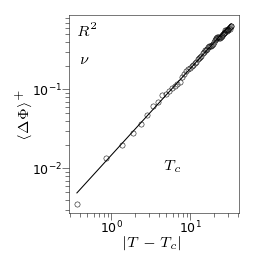

In [100]:
draw_law(renorm, y, r_value**2, save=False)

In [23]:
len(item[0])

4500

In [32]:
for n, item in enumerate(items):
    for t, frame in enumerate(np.array(item[0])):
        for i in range(n_moto):
            if frame[-i]["a_des"] != frame[-i]["a0"]:
                print(n, t, i)
            # break
    # else:
    #    continue  # only executed if the inner loop did NOT break
    # break  # only executed if the inner loop DID break

In [34]:
frame[-i]

{'ID': 26,
 'mode': 'Moto',
 'a_des': -0.009858113405270973,
 'a0': -0.009858113405270973,
 'ttc': None,
 'f_a': [3.8854588135835275,
  4.05106849333542,
  4.2465185373669785,
  4.486987106748825,
  4.807469414942023,
  5.3566681688804385,
  9.853200782679291,
  10.027937327800965,
  10.238390880723914,
  10.49516297265259,
  10.816841005835105,
  11.241853924826703,
  11.884090929248151,
  18.334961042750848,
  19.13854686653137,
  28.485277736684505,
  39.58051515758536,
  40.0,
  40.0,
  40.0,
  40.0,
  40.0,
  18.51109166398875,
  17.65140999191834,
  17.134843077652608,
  9.940762337852341,
  9.285913760772239,
  8.855011010131767,
  8.526373580557717,
  8.260428553744598,
  8.038208657870818,
  7.84891496162435,
  7.6857163657746055,
  7.543996135567541,
  7.4204969483941685,
  7.312843508915332,
  7.219282265842969],
 'leader': 25,
 'gap': 9.168670810429363,
 'tau': 0.22214705442571359,
 'lam': 2.5755748594187637,
 'v0': 9.328459890582964,
 'd': 0.7961151889667952,
 'pos': [17.0

In [35]:
start = int(len(item[0]) * 2 / 3 - 1)
start

2999

In [36]:
len(items)

32

In [37]:
for n, item in enumerate(items):
    # ar = np.array(item[0])
    l_T = []
    l_DPhi = []
    frames = []
    # for item in items:
    # if isinstance(item[0], list):
    for t, frame in enumerate(item[0]):
        if t > start:
            deg_range = []
            vel_car = []
            vel_x = []
            vel_y = []
            for j, _ in enumerate(frame):
                vel = frame[j]["vel"]
                v0 = frame[j]["v0"]
                lam = frame[j]["lam"]
                d = frame[j]["d"]
                v_max = ov(params.d_max, lam, v0, d)
                if frame[j]["mode"] == "Car":
                    vel_car.append(vel[0] / v_max)
                else:
                    alphas = decay(array(vel), frame[j]["theta"])
                    degs = np.degrees(alphas)
                    deg_range.append(degs[0] - degs[-1])
                    vel_x.append(vel[0] / v_max)
                    vel_y.append(vel[1] / v_max)
            if np.round(mean(deg_range)) / 2 == 40.5:
                frames.append(t)
                l_T.append(mean(deg_range))
                phi_cars = mean(vel_car)
                phi_moto = norm([sum(vel_x), sum(vel_y)]) / n_moto
                l_DPhi.append(phi_moto - phi_cars)
    l_T = np.round(l_T) / 2
    if len(l_T) > 0:
        print(n)

3
6
10
13
16
17
18
22
27
28
30
31


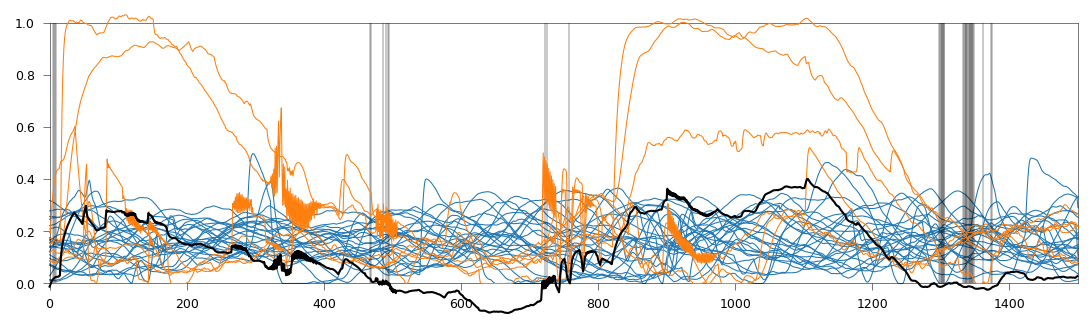

In [38]:
fig, ax = plt.subplots(figsize=(18 * params.cm, 5 * params.cm), dpi=150)
item = items[22]
ar = np.array(item[0])
for i in range(ar.shape[1]):
    speeds = []
    for d in ar[start::1, -(i + 1)]:
        v_max = ov(params.d_max, d["lam"], d["v0"], d["d"])
        speed = d["vel"][0] / v_max
        speeds.append(speed)
    if d["mode"] == "Car":
        zorder = 0
        c = "tab:blue"
    else:
        zorder = 10
        c = "tab:orange"
    plt.plot(speeds, c=c, lw=0.5, clip_on=False, zorder=zorder)
if n_moto > 0:
    l_DPhi = []
    for t, frame in enumerate(item[0]):
        if t > start:
            deg_range = []
            vel_car = []
            vel_x = []
            vel_y = []
            for j, _ in enumerate(frame):
                vel = frame[j]["vel"]
                v0 = frame[j]["v0"]
                lam = frame[j]["lam"]
                d = frame[j]["d"]
                v_max = ov(params.d_max, lam, v0, d)
                if frame[j]["mode"] == "Car":
                    vel_car.append(vel[0] / v_max)
                else:
                    alphas = decay(array(vel), frame[j]["theta"])
                    degs = np.degrees(alphas)
                    deg_range.append(degs[0] - degs[-1])
                    vel_x.append(vel[0] / v_max)
                    vel_y.append(vel[1] / v_max)
            phi_cars = mean(vel_car)
            phi_moto = norm([sum(vel_x), sum(vel_y)]) / n_moto
            l_DPhi.append(phi_moto - phi_cars)
            temperature = np.round(mean(deg_range)) / 2
            if temperature == 40.5:
                plt.axvline(t - start, c="k", ls="-", lw=0.2)
    plt.plot(l_DPhi, c="k", lw=1, clip_on=False, zorder=100)
ax.set_xlim(0, ar.shape[0] - (start + 1))
ax.set_ylim(0, 1)
fig.tight_layout(pad=0)

In [39]:
l_T = []
l_DPhi = []
frames = []
# for item in items:
# if isinstance(item[0], list):
for t, frame in enumerate(item[0]):
    if t > start:
        deg_range = []
        vel_car = []
        vel_x = []
        vel_y = []
        for j, _ in enumerate(frame):
            vel = frame[j]["vel"]
            v0 = frame[j]["v0"]
            lam = frame[j]["lam"]
            d = frame[j]["d"]
            v_max = ov(params.d_max, lam, v0, d)
            if frame[j]["mode"] == "Car":
                vel_car.append(vel[0] / v_max)
            else:
                alphas = decay(array(vel), frame[j]["theta"])
                degs = np.degrees(alphas)
                deg_range.append(degs[0] - degs[-1])
                vel_x.append(vel[0] / v_max)
                vel_y.append(vel[1] / v_max)
        if np.round(mean(deg_range)) / 2 == 40.5:
            # print(t)
            frames.append(t)
            l_T.append(mean(deg_range))
            phi_cars = mean(vel_car)
            phi_moto = norm([sum(vel_x), sum(vel_y)]) / n_moto
            l_DPhi.append(phi_moto - phi_cars)
l_T = np.round(l_T) / 2

In [40]:
def draw(agent, ax):
    """Add this Particle's Ellipse patch to the Matplotlib Axes ax."""
    if agent["mode"] == "Car":
        width = 2 * params.car_l
        height = 2 * params.car_w
    else:
        width = 2 * params.moto_l
        height = 2 * params.moto_w
    ellipse = Ellipse(
        xy=agent["pos"],
        width=width,
        height=height,
        angle=degrees(agent["theta"]),
        **{"ec": "k", "fc": "w"},
    )
    ax.add_patch(ellipse)
    ax.scatter(
        agent["pos"][0],
        agent["pos"][1],
        marker="o",
        fc="k",
        ec="none",
        s=5,
    )
    if norm(agent["vel"]) > 0:
        ax.arrow(
            agent["pos"][0],
            agent["pos"][1],
            agent["vel"][0],
            agent["vel"][1],
            antialiased=True,
            width=0.1,
            head_width=0.5,
            head_length=0.75,
            color="k",
            zorder=2,
        )

In [41]:
def ring(t, l_agents, ax):
    ax.set_aspect("equal")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-params.L / 2, params.L / 2)
    ax.set_ylim(-params.lane, params.lane)
    ax.set_axis_off()
    ax.hlines(
        [-params.lane, params.lane],
        xmin=-params.L / 2,
        xmax=params.L / 2,
        color="k",
        ls="-",
        lw=3,
    )
    for agent in l_agents[t]:
        if agent["pos"][0] < params.d_max:
            image = deepcopy(agent)
            image["pos"][0] += params.L
            draw(image, ax)
        elif agent["pos"][0] > params.d_max:
            image = deepcopy(agent)
            image["pos"][0] -= params.L
            draw(image, ax)
        draw(agent, ax)

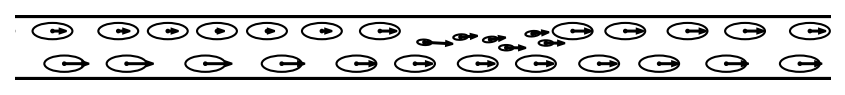

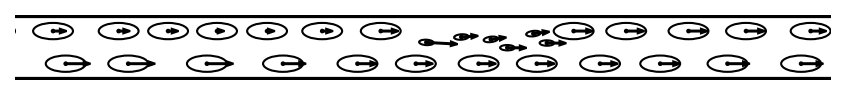

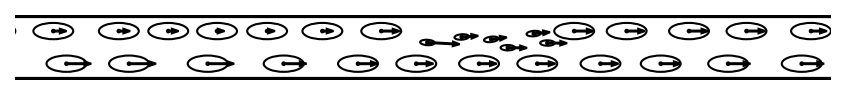

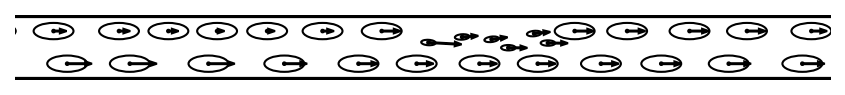

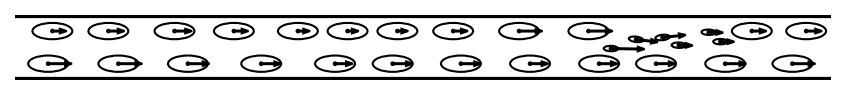

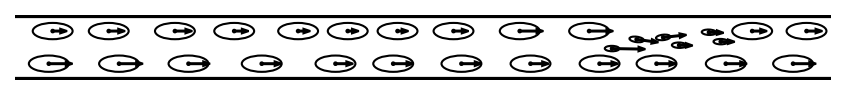

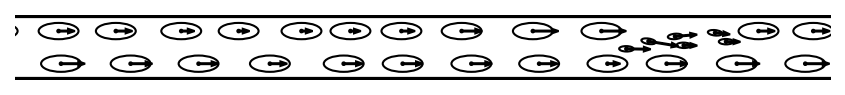

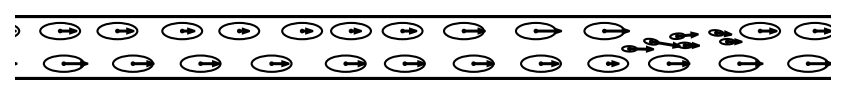

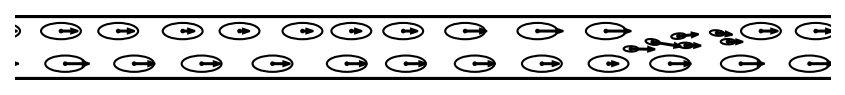

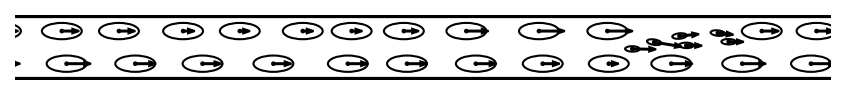

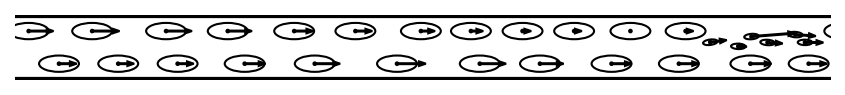

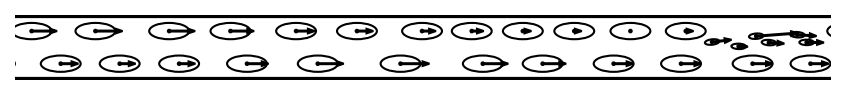

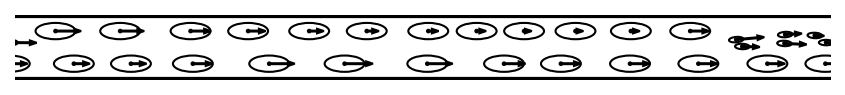

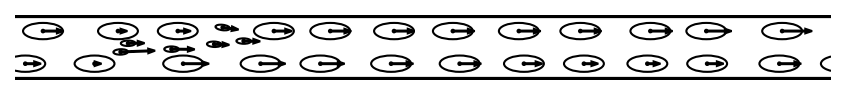

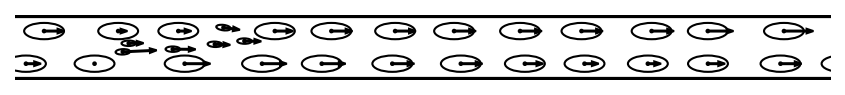

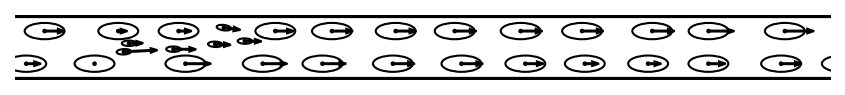

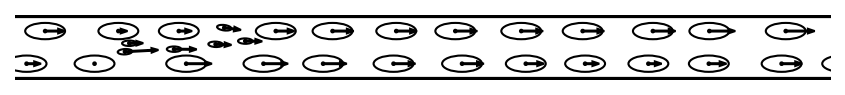

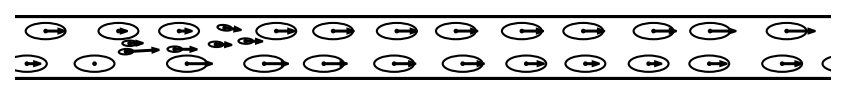

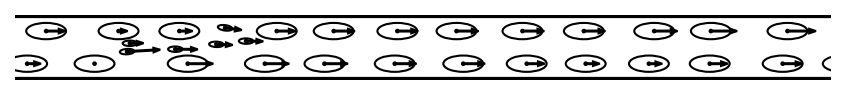

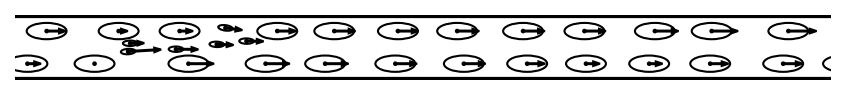

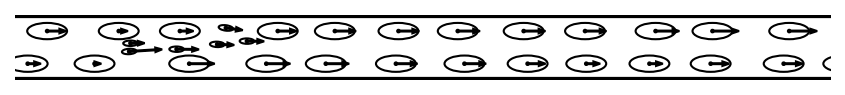

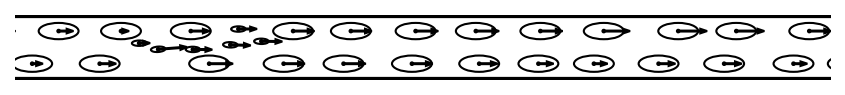

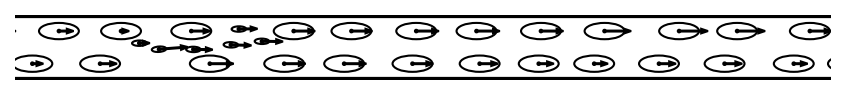

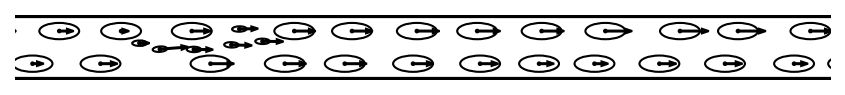

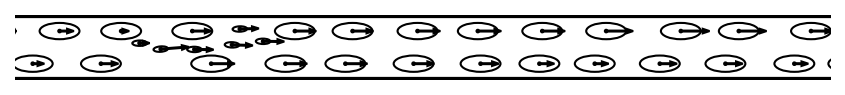

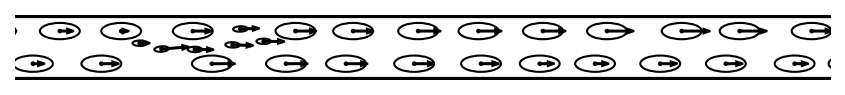

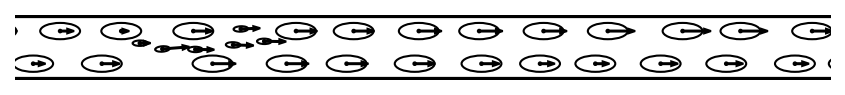

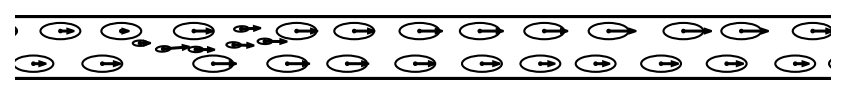

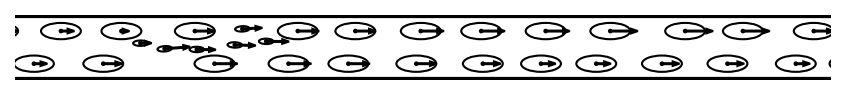

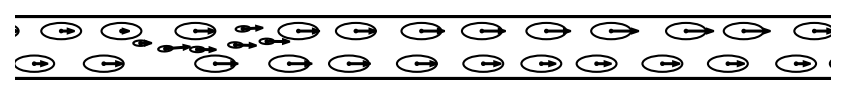

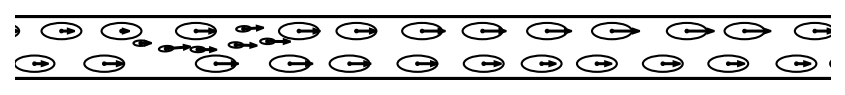

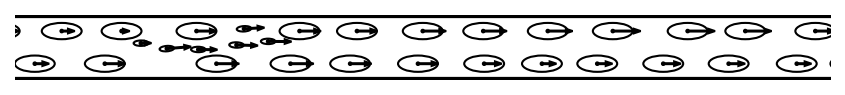

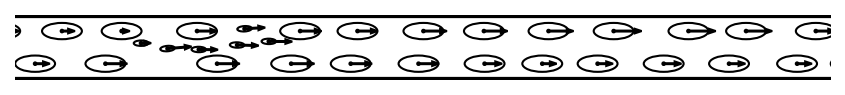

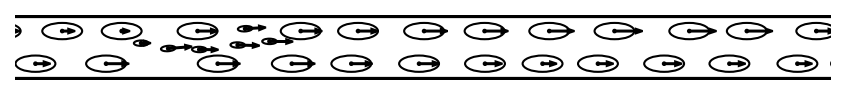

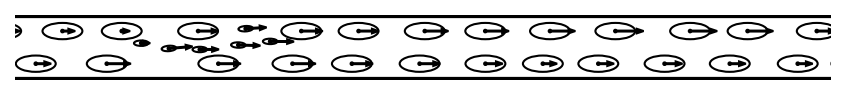

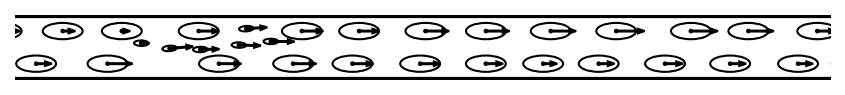

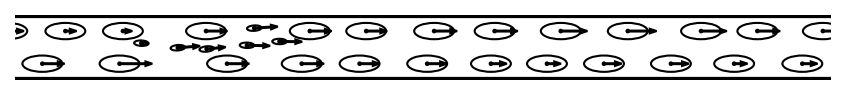

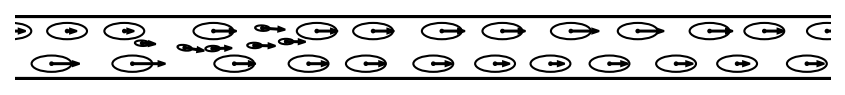

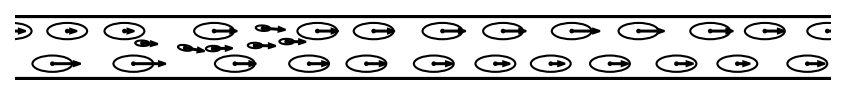

In [42]:
for frame in frames[:]:
    fig, ax = plt.subplots(figsize=(14.7 * params.cm, 2.5 * params.cm), dpi=150)
    fig.tight_layout(pad=0)
    ax.set_aspect("equal")
    ring(int(frame), item[0], ax)